In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [4]:
def read_data(url):
    df = pd.read_csv(url)
    df = df.loc[df[" utilization.gpu [%]"] > 0] #isolating training 
    #print(df.columns)
    return df

In [5]:
def time_duration(df):
    df.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df.timestamp]
    time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
    #print("Total time in seconds: {}".format(time_interval.total_seconds()))
    return time_interval.total_seconds()

In [6]:
def power_reading(url):
    df = read_data(url)
    time_interval = time_duration(df)
    df_gpu1 = df.iloc[::2]
    df_gpu2 = df.iloc[1::2]
    mean_power = df[' power.draw [W]'].mean() # refer notebook on time series
    total_power = mean_power * time_interval * 2 / (1000 *60*60)
    summed_power = df[' power.draw [W]'].sum() / (1000 *60*60)
    gpu1_mean = df_gpu1[' power.draw [W]'].mean()
    gpu2_mean = df_gpu2[' power.draw [W]'].mean()
    gpu1_util = df_gpu1[' utilization.gpu [%]'].mean()
    gpu2_util = df_gpu2[' utilization.gpu [%]'].mean()
    gpu_util = (gpu1_util + gpu2_util) / 2
    memory_util = df[' utilization.memory [%]'].mean()
    memory_used = df[' memory.used [MiB]'].mean()
    extract = url.split('/')[1].replace(".","_").split('_')
    end_time = df.iloc[-1].timestamp
    start_time = df.iloc[0].timestamp
    data = []
    if (extract[2] != 'pretrain'):
        data = [extract[2], extract[3], extract[4],
                mean_power,time_interval,total_power,summed_power,gpu_util,
                gpu1_util,gpu2_util,gpu1_mean,gpu2_mean,
                memory_util,memory_used, start_time, end_time]
#     else:
#         data = [extract[2], None, None,
#                 mean_power,time_interval,total_power,gpu_util,memory_util,memory_used]
    return df, data

In [7]:
import os
folder_name = 'nvidia'
result = pd.DataFrame(columns=['dataset','batchsize','max_seq_len',
                               'mean_power','total_time','power','summed_power','gpu_util',
                               'gpu1_util','gpu2_util','gpu1_mean_power','gpu2_mean_power',
                               'memory_util','memory_used',
                               'start_time','end_time'])

for file_name in os.listdir(folder_name):
    #print(file_name)
    if(file_name != '.DS_Store'):
        url = folder_name + '/' + file_name
        df,data = power_reading(url)
       # print (data)
        if data:
            result =result.append(pd.Series(data, index=result.columns),ignore_index=True)
    #print ("-------------------------------------------")

In [8]:
# https://www.tensorflow.org/datasets/catalog/glue
train_dataset_sizes = {
    'MRPC': 3668,
    'CoLA': 8551,
    'SST-2':67349,
    'MNLI': 392702,
    'STS-B':8628,
    'STS-B':5749,
    'QQP':  363846,
    'RTE':  2490,
    'QNLI': 104743,
    'WNLI': 635
}

In [9]:
result['dataset_size'] = result['dataset']
result["dataset_size"].replace(train_dataset_sizes, inplace=True)

In [10]:
result[["batchsize","max_seq_len"]] = result[["batchsize","max_seq_len"]].apply(pd.to_numeric)
result["total_batchsize"] = result["batchsize"] * 2
result["samples_per_sec"] = (result["dataset_size"] * 3) / result.total_time #3 epochs
result["time_per_sample"] = result.total_time /(result["dataset_size"] * 3)
result.head()

,dataset,batchsize,max_seq_len,mean_power,total_time,power,summed_power,gpu_util,gpu1_util,gpu2_util,gpu1_mean_power,gpu2_mean_power,memory_util,memory_used,start_time,end_time,dataset_size,total_batchsize,samples_per_sec,time_per_sample
0,WNLI,32,128,182.903548,16.122,0.001638,0.001575,79.360417,76.187500,82.533333,176.130625,190.128000,29.387097,4707.870968,2020-06-19 16:13:45.856,2020-06-19 16:14:01.978,635,64,118.161518,0.008463
1,SST-2,16,256,211.759289,493.516,0.058059,0.057116,93.375404,91.858025,94.892784,209.406523,214.116907,38.238929,6151.259526,2020-06-13 15:58:07.779,2020-06-13 16:06:21.295,67349,32,409.403140,0.002443
2,MRPC,28,128,204.860397,77.174,0.008783,0.008593,91.133070,86.039474,96.226667,200.702500,209.073733,34.264901,4803.768212,2020-06-13 20:27:00.615,2020-06-13 20:28:17.789,3668,56,142.586882,0.007013
3,RTE,64,128,225.741977,43.493,0.005455,0.005393,90.220930,93.023256,87.418605,227.256744,224.227209,38.279070,8139.453488,2020-06-22 10:42:08.666,2020-06-22 10:42:52.159,2490,128,171.751776,0.005822
4,STS-B,64,128,237.987861,102.504,0.013553,0.013288,95.063168,92.366337,97.760000,235.352772,240.649300,38.661692,8401.965174,2020-06-22 10:44:57.767,2020-06-22 10:46:40.271,5749,128,168.256849,0.005943


In [11]:
# approx flops using the ai and compute equation
# Number of GPUs * (peta-flops/GTX580) * days trained * estimated utilization
gtx1080TFLOPS = 11.34  # https://www.techpowerup.com/gpu-specs/geforce-gtx-1080-ti.c2877
result['TFLOPs'] = 2 * gtx1080TFLOPS *  result['total_time'] * result['gpu_util']
result['PFLOPs'] = result['TFLOPs'] / 1000
result['PFLOPs_per_example'] = result['PFLOPs'] / (result["dataset_size"] * 3)

In [12]:
# rename file when ready and use that instead of the above steps
# import time
# result_file = "results/result"+ str(int(time.time()))+".csv"
# result.to_csv(result_file, index=False)

In [13]:
result.head()

,dataset,batchsize,max_seq_len,mean_power,total_time,power,summed_power,gpu_util,gpu1_util,gpu2_util,...,memory_used,start_time,end_time,dataset_size,total_batchsize,samples_per_sec,time_per_sample,TFLOPs,PFLOPs,PFLOPs_per_example
0,WNLI,32,128,182.903548,16.122,0.001638,0.001575,79.360417,76.187500,82.533333,...,4707.870968,2020-06-19 16:13:45.856,2020-06-19 16:14:01.978,635,64,118.161518,0.008463,2.901790e+04,29.017895,0.015232
1,SST-2,16,256,211.759289,493.516,0.058059,0.057116,93.375404,91.858025,94.892784,...,6151.259526,2020-06-13 15:58:07.779,2020-06-13 16:06:21.295,67349,32,409.403140,0.002443,1.045146e+06,1045.145564,0.005173
2,MRPC,28,128,204.860397,77.174,0.008783,0.008593,91.133070,86.039474,96.226667,...,4803.768212,2020-06-13 20:27:00.615,2020-06-13 20:28:17.789,3668,56,142.586882,0.007013,1.595108e+05,159.510789,0.014496
3,RTE,64,128,225.741977,43.493,0.005455,0.005393,90.220930,93.023256,87.418605,...,8139.453488,2020-06-22 10:42:08.666,2020-06-22 10:42:52.159,2490,128,171.751776,0.005822,8.899584e+04,88.995842,0.011914
4,STS-B,64,128,237.987861,102.504,0.013553,0.013288,95.063168,92.366337,97.760000,...,8401.965174,2020-06-22 10:44:57.767,2020-06-22 10:46:40.271,5749,128,168.256849,0.005943,2.210020e+05,221.001972,0.012814


In [14]:
result.PFLOPs_per_example.describe()

count    39.000000
mean      0.015682
std       0.005452
min       0.005173
25%       0.012640
50%       0.014068
75%       0.015693
max       0.031031
Name: PFLOPs_per_example, dtype: float64

### Test impact of batchsize on GPU utilisation, memory utilisation, total time and power consumed

In [15]:
df_mrpc = result.loc[(result.dataset == 'MRPC') & (result.max_seq_len == 128)]
df_mrpc =df_mrpc.sort_values('batchsize')
df_mrpc

,dataset,batchsize,max_seq_len,mean_power,total_time,power,summed_power,gpu_util,gpu1_util,gpu2_util,...,memory_used,start_time,end_time,dataset_size,total_batchsize,samples_per_sec,time_per_sample,TFLOPs,PFLOPs,PFLOPs_per_example
9,MRPC,16,128,185.643234,101.920,0.010512,0.010365,90.309505,84.099010,96.520000,...,3587.029851,2020-06-22 13:25:43.190,2020-06-22 13:27:25.110,3668,32,107.967033,0.009262,208754.538806,208.754539,0.018971
7,MRPC,20,128,193.060506,90.725,0.009731,0.009546,90.129213,85.404494,94.853933,...,4050.230337,2020-06-13 20:18:29.390,2020-06-13 20:20:00.115,3668,40,121.289611,0.008245,185453.745219,185.453745,0.016853
34,MRPC,24,128,208.408171,83.879,0.009712,0.009494,91.000000,86.926829,95.073171,...,4435.317073,2020-06-13 20:24:49.507,2020-06-13 20:26:13.386,3668,48,131.188975,0.007623,173116.190520,173.116191,0.015732
2,MRPC,28,128,204.860397,77.174,0.008783,0.008593,91.133070,86.039474,96.226667,...,4803.768212,2020-06-13 20:27:00.615,2020-06-13 20:28:17.789,3668,56,142.586882,0.007013,159510.788689,159.510789,0.014496
12,MRPC,32,128,207.326933,76.812,0.008847,0.008639,91.460000,87.240000,95.680000,...,5195.920000,2020-06-22 13:18:44.049,2020-06-22 13:20:00.861,3668,64,143.258866,0.006980,159332.114794,159.332115,0.014479
13,MRPC,40,128,215.501631,71.807,0.008597,0.008440,92.079276,93.901408,90.257143,...,6020.312057,2020-06-13 20:37:13.270,2020-06-13 20:38:25.077,3668,80,153.244113,0.006526,149958.720883,149.958721,0.013628
17,MRPC,48,128,222.867895,67.682,0.008380,0.008234,93.821574,90.552239,97.090909,...,6779.187970,2020-06-13 20:51:52.487,2020-06-13 20:53:00.169,3668,96,162.583848,0.006151,144018.720498,144.018720,0.013088
33,MRPC,56,128,229.412460,63.976,0.008154,0.008029,92.515873,95.507937,89.523810,...,7569.753968,2020-06-14 23:56:04.578,2020-06-14 23:57:08.554,3668,112,172.002001,0.005814,134238.281760,134.238282,0.012199
10,MRPC,64,128,238.336613,62.892,0.008327,0.008209,93.104839,95.516129,90.693548,...,8270.129032,2020-06-22 13:52:18.530,2020-06-22 13:53:21.422,3668,128,174.966609,0.005715,132803.863026,132.803863,0.012069


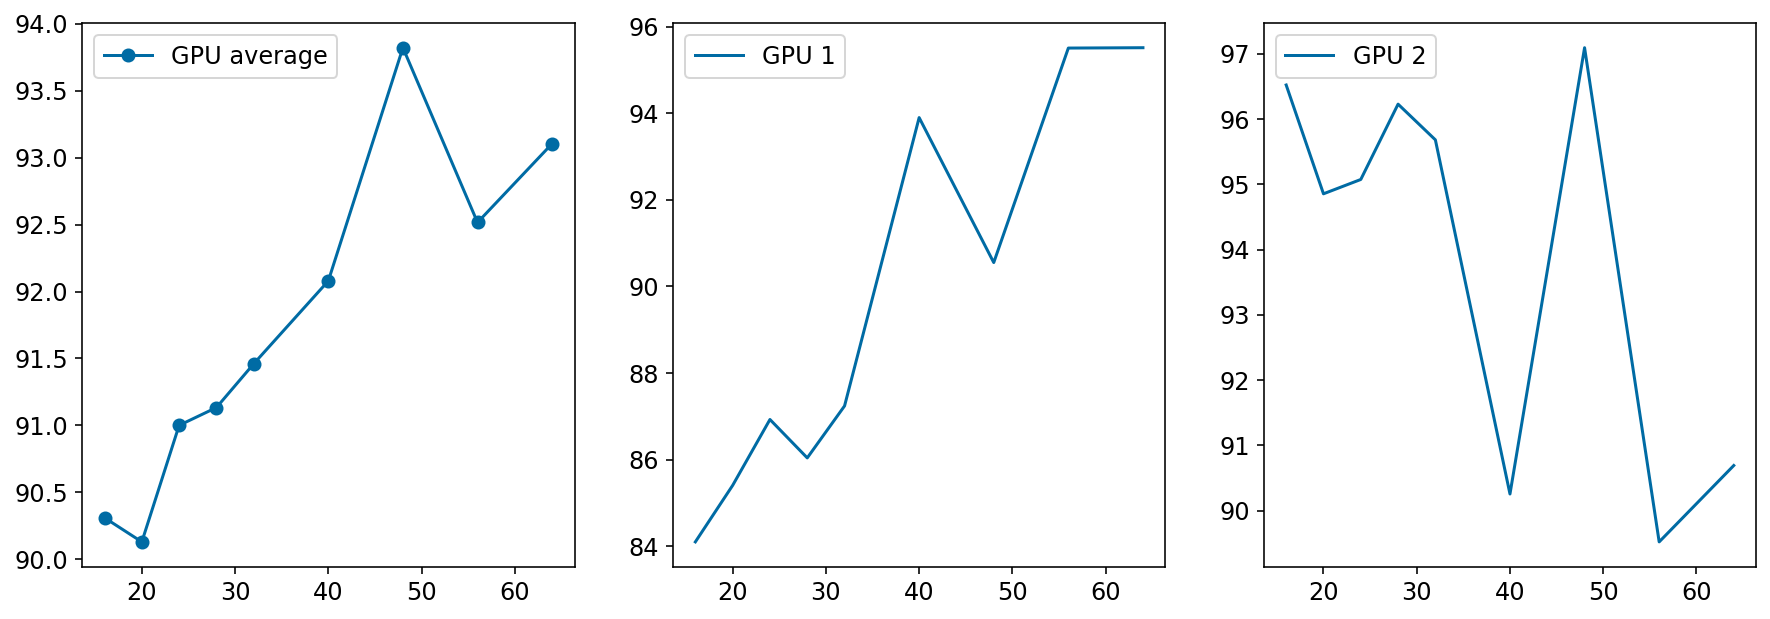

In [16]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(df_mrpc['batchsize'],df_mrpc["gpu_util"],'-o', label="GPU average")
axs[1].plot(df_mrpc['batchsize'],df_mrpc["gpu1_util"], label="GPU 1")
axs[2].plot(df_mrpc['batchsize'],df_mrpc["gpu2_util"], label="GPU 2")
axs[0].legend()
axs[1].legend()
axs[2].legend()

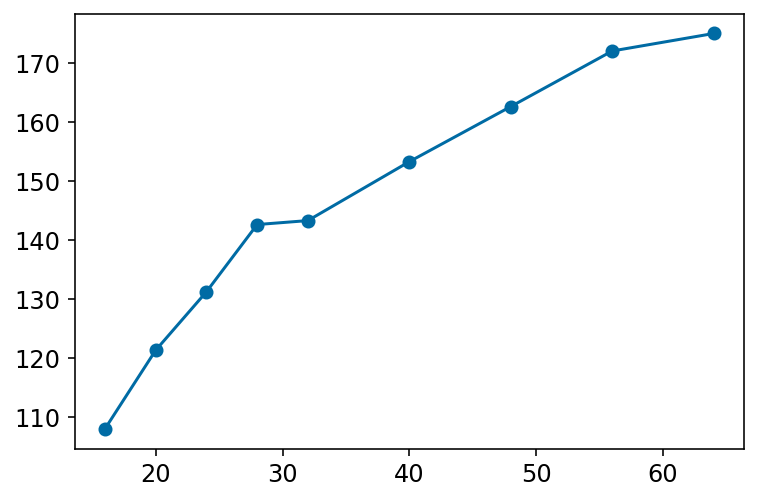

In [17]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["samples_per_sec"],'-o')

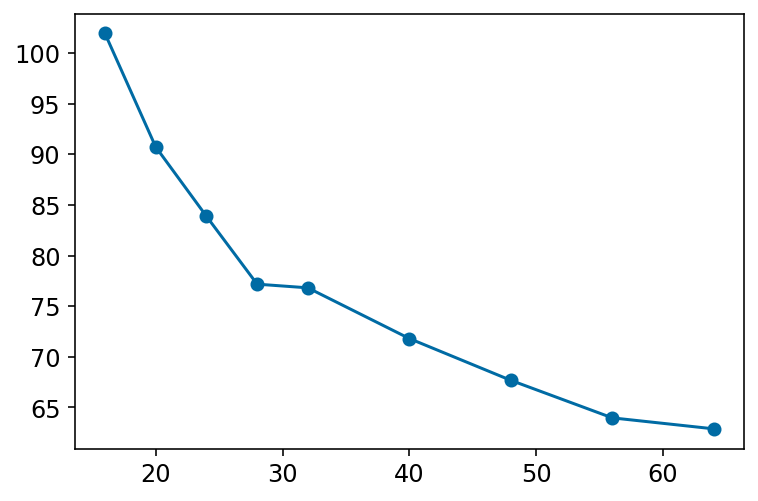

In [18]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["total_time"],'-o')

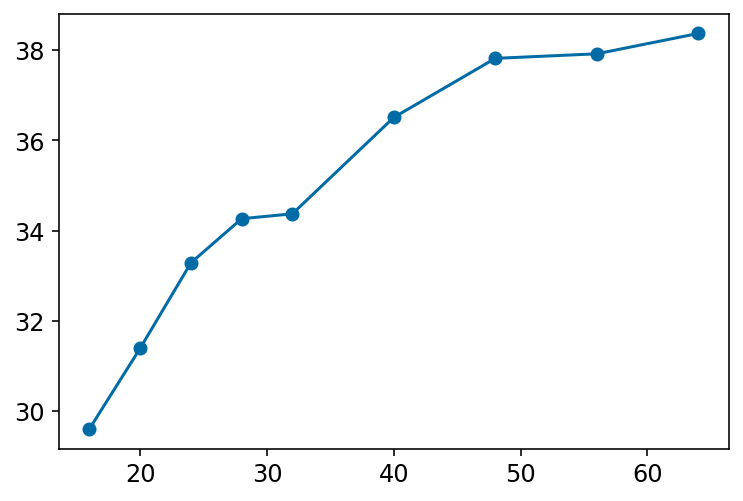

In [19]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["memory_util"],'-o')

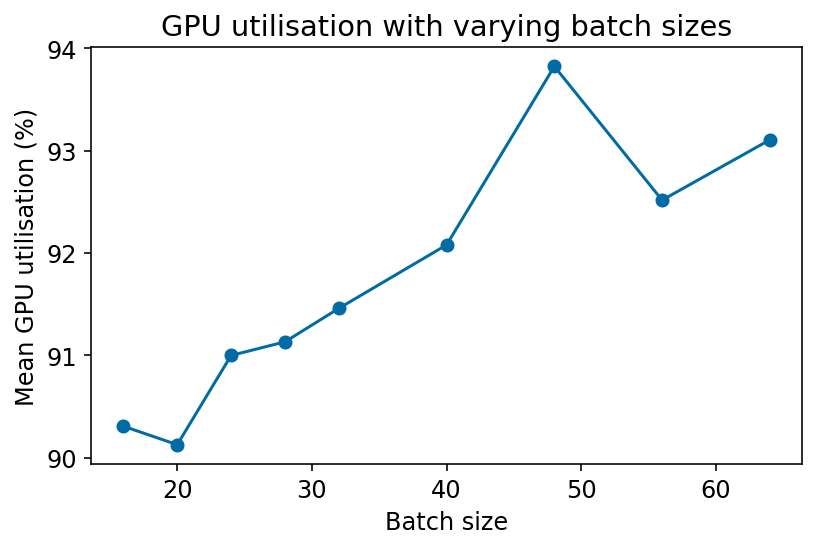

In [20]:
plt.plot(df_mrpc['batchsize'],df_mrpc["gpu_util"],'-o')
plt.xlabel("Batch size")
plt.ylabel("Mean GPU utilisation (%)")
plt.title("GPU utilisation with varying batch sizes")
plt.tight_layout()
plt.savefig("viz/gpuUtilBatchSize.png")

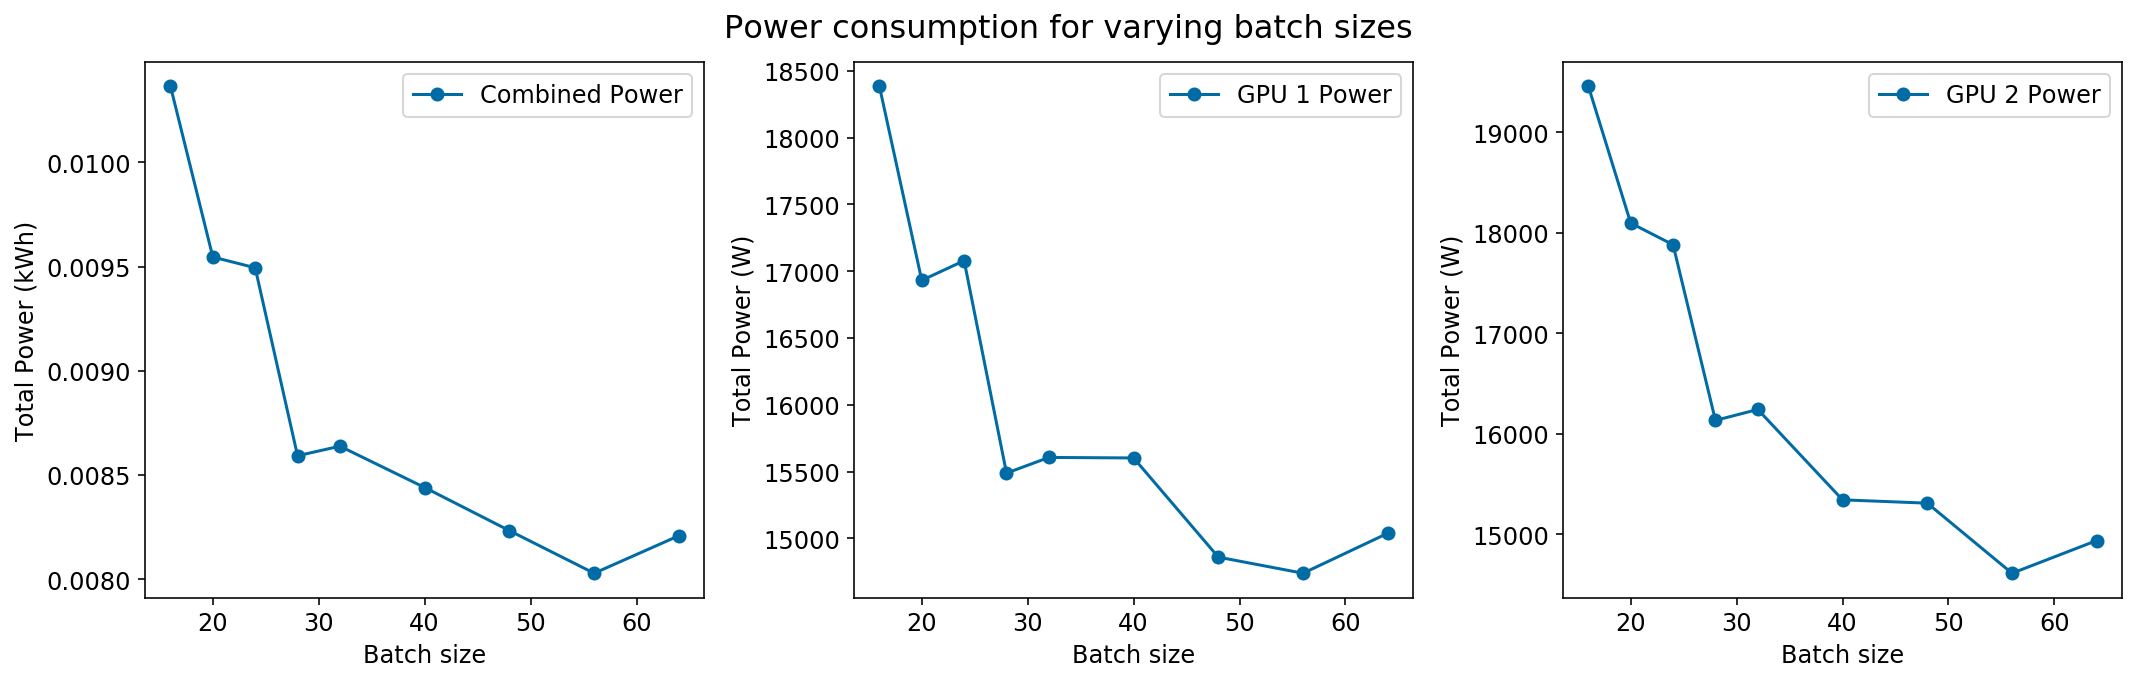

In [21]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(df_mrpc['batchsize'],df_mrpc["summed_power"],'-o', label="Combined Power")
axs[1].plot(df_mrpc['batchsize'],df_mrpc["gpu1_mean_power"]* df_mrpc['total_time'], '-o',label="GPU 1 Power")
axs[2].plot(df_mrpc['batchsize'],df_mrpc["gpu2_mean_power"]* df_mrpc['total_time'], '-o', label="GPU 2 Power")
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.setp(axs[:], xlabel='Batch size')
plt.setp(axs[0], ylabel='Total Power (kWh)')
plt.setp(axs[1:3], ylabel='Total Power (W)')
plt.suptitle("Power consumption for varying batch sizes",fontsize='16')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
plt.savefig("viz/batchsizeVsPower.png")

Increasing batchsize leads to less time probably due to better gpu utilisation and more memory used.
The power consumed decreases with increasing batchsize.

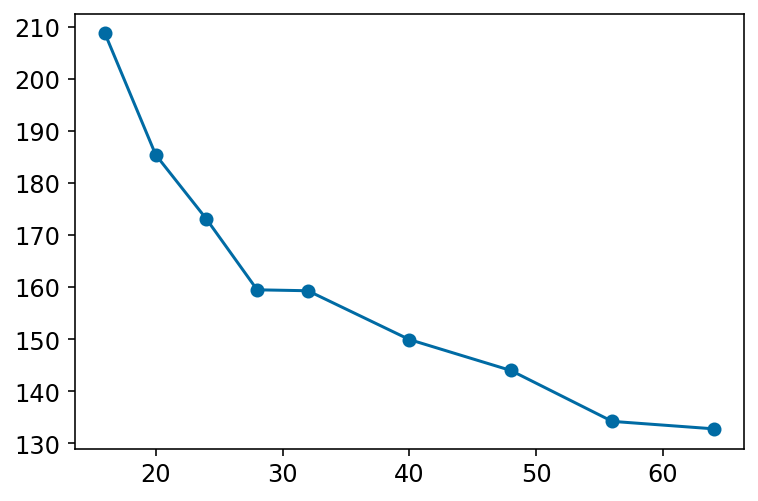

In [22]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["PFLOPs"],'-o')

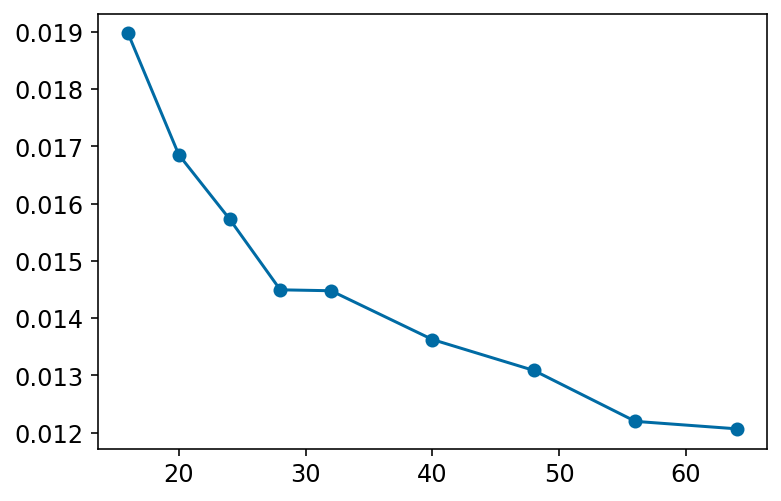

In [23]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["PFLOPs_per_example"],'-o')

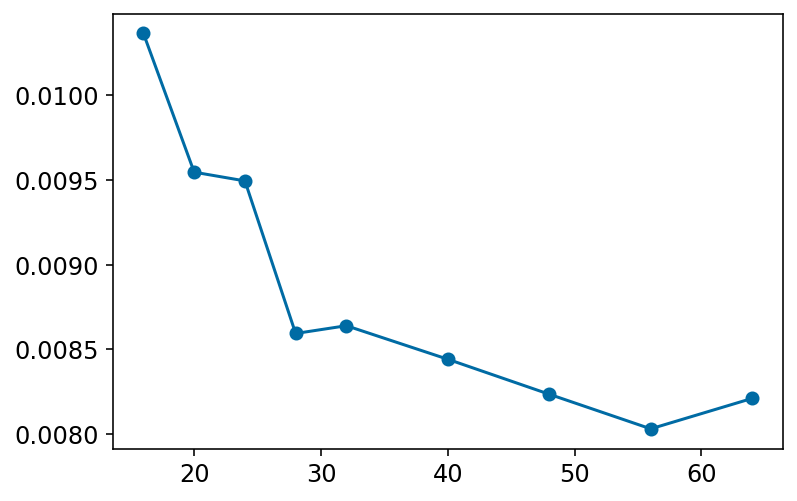

In [24]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["summed_power"],'-o')

## Test correlation between dataset size (number of samples used for training) and time/power consumed

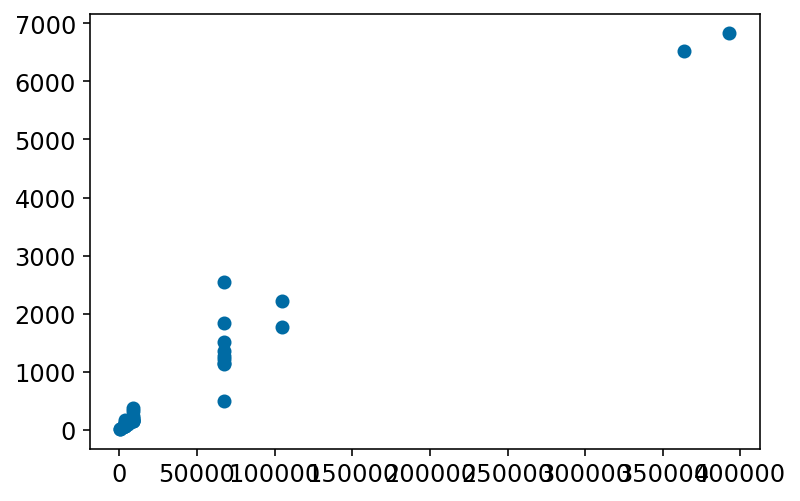

In [25]:
ax = plt.scatter(result['dataset_size'],result["total_time"])

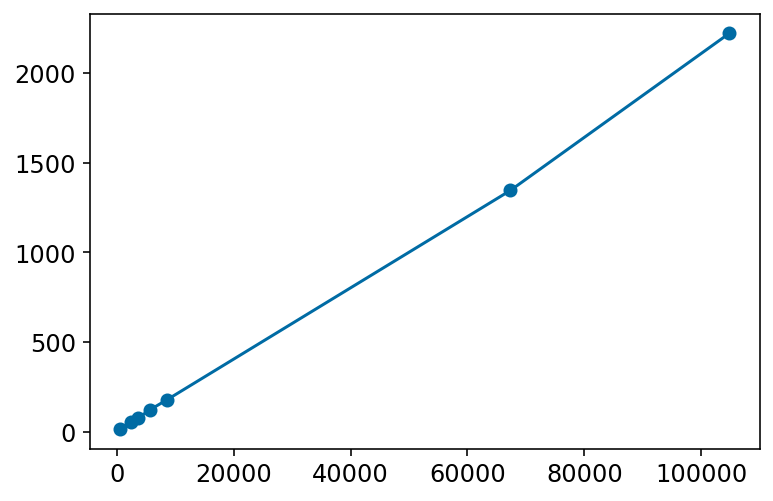

In [26]:
# Using subset with batch size 32 (64 total for 2 GPUs) and max_seq_len 128

subset_32_128 = result.loc[(result.batchsize == 32) & (result.max_seq_len == 128)]
subset_32_128 = subset_32_128.sort_values('dataset_size')
plt.plot(subset_32_128['dataset_size'],subset_32_128["total_time"],'-o')

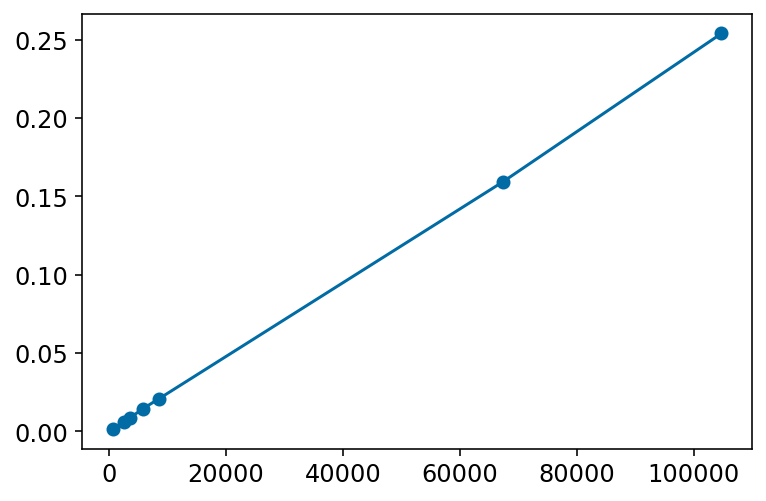

In [27]:
plt.plot(subset_32_128['dataset_size'],subset_32_128["power"],'-o')

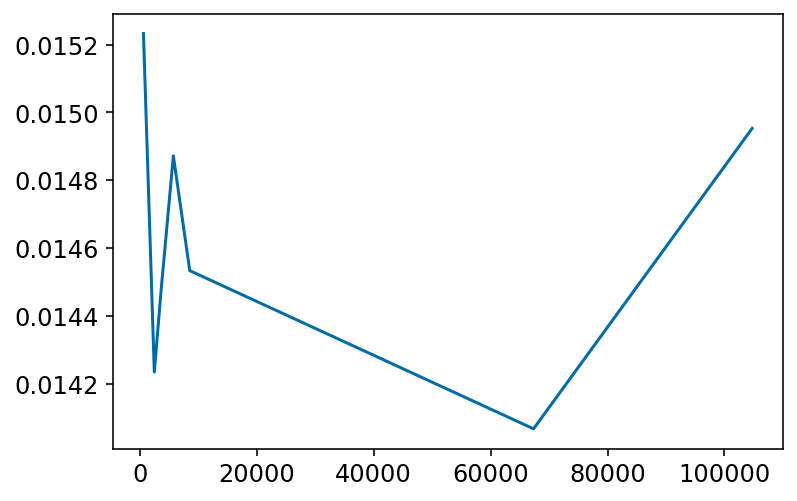

In [28]:
plt.plot(subset_32_128['dataset_size'],subset_32_128["PFLOPs_per_example"])

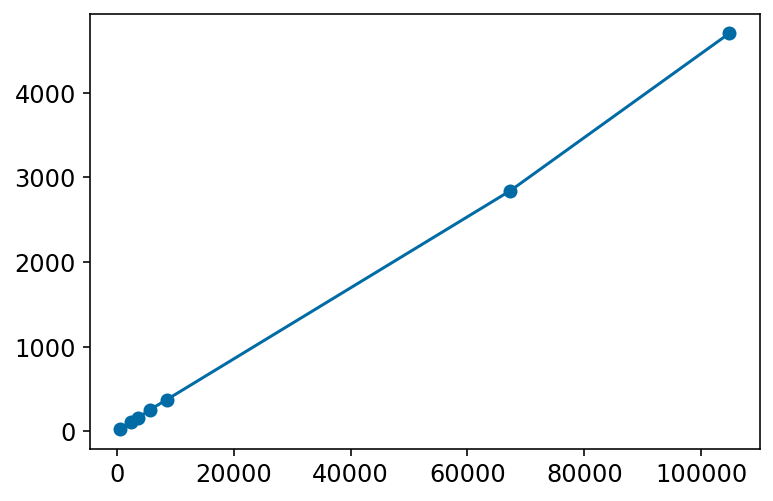

In [29]:
plt.plot(subset_32_128['dataset_size'],subset_32_128["PFLOPs"],'-o')

In [32]:
from sklearn.linear_model import LinearRegression
from scipy import stats
X = subset_32_128[['dataset_size']]
y = subset_32_128["power"]
reg = LinearRegression().fit(X, y)
print (reg.coef_)
print (reg.intercept_)
print ("R2 score:",reg.score(X, y))

[2.40769738e-06]
-6.363220039665163e-05
R2 score: 0.9997995814489106


In [33]:
X = subset_32_128[['dataset_size']]
y = subset_32_128["total_time"]
reg = LinearRegression().fit(X, y)
print (reg.coef_)
print (reg.intercept_)
print ("R2 score:",reg.score(X, y))

[0.02089281]
-3.4575793901950647
R2 score: 0.9989440433107479


This linear relation implies if we vary just the dataset size keeping all variables same, power consumed and total runtime can be predicted. (Directly proportional) \
Thus if we know time taken to process one sample, we can extrapolate time taken for x samples. \
The less quantity of data bothers me.

In [34]:
subset_64_128 = result.loc[(result.batchsize == 64) & (result.max_seq_len == 128)]
subset_64_128 = subset_64_128.sort_values('dataset_size')


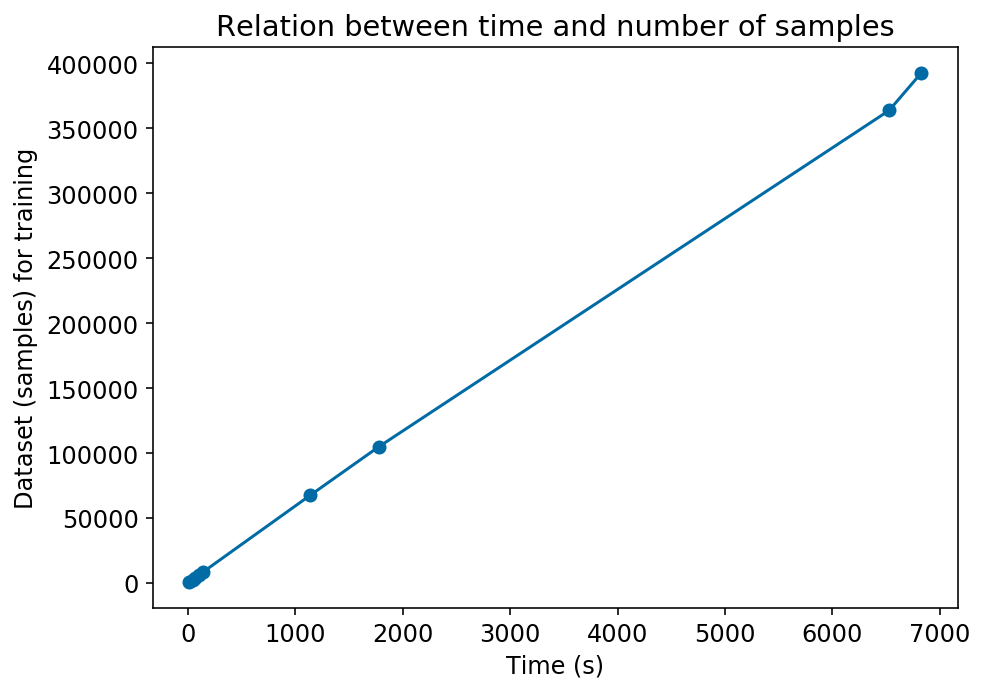

In [35]:
plt.figure(figsize=(7,5))
ax = plt.plot(subset_64_128["total_time"],subset_64_128['dataset_size'],  "-o")
plt.title("Relation between time and number of samples")
plt.xlabel("Time (s)")
plt.ylabel("Dataset (samples) for training")
plt.tight_layout()
plt.savefig("viz/dataTimePlot.png", dpi=300)

In [36]:
X = subset_64_128[['dataset_size']]
y = subset_64_128["total_time"]
reg = LinearRegression().fit(X, y)
print ("Coefficient: ",reg.coef_)
print ("Intercept: ",reg.intercept_)
print ("R2 score:",reg.score(X, y))

Coefficient:  [0.01765063]
Intercept:  -14.622078835986258
R2 score: 0.999549219986691


In [41]:
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_64_128['dataset_size'],subset_64_128["total_time"] )
print(f"slope {slope} \nintercept {intercept}\nr_value {r_value}\np_value {p_value}\nstd_err {std_err}")
print('R squared ', r_value ** 2)

slope 0.017650630976836522 
intercept -14.622078835986713
r_value 0.9997745845872915
p_value 5.660887069225805e-13
std_err 0.00014167442181725612
R squared  0.9995492199866913


In [81]:
#reg.predict([[101103]])

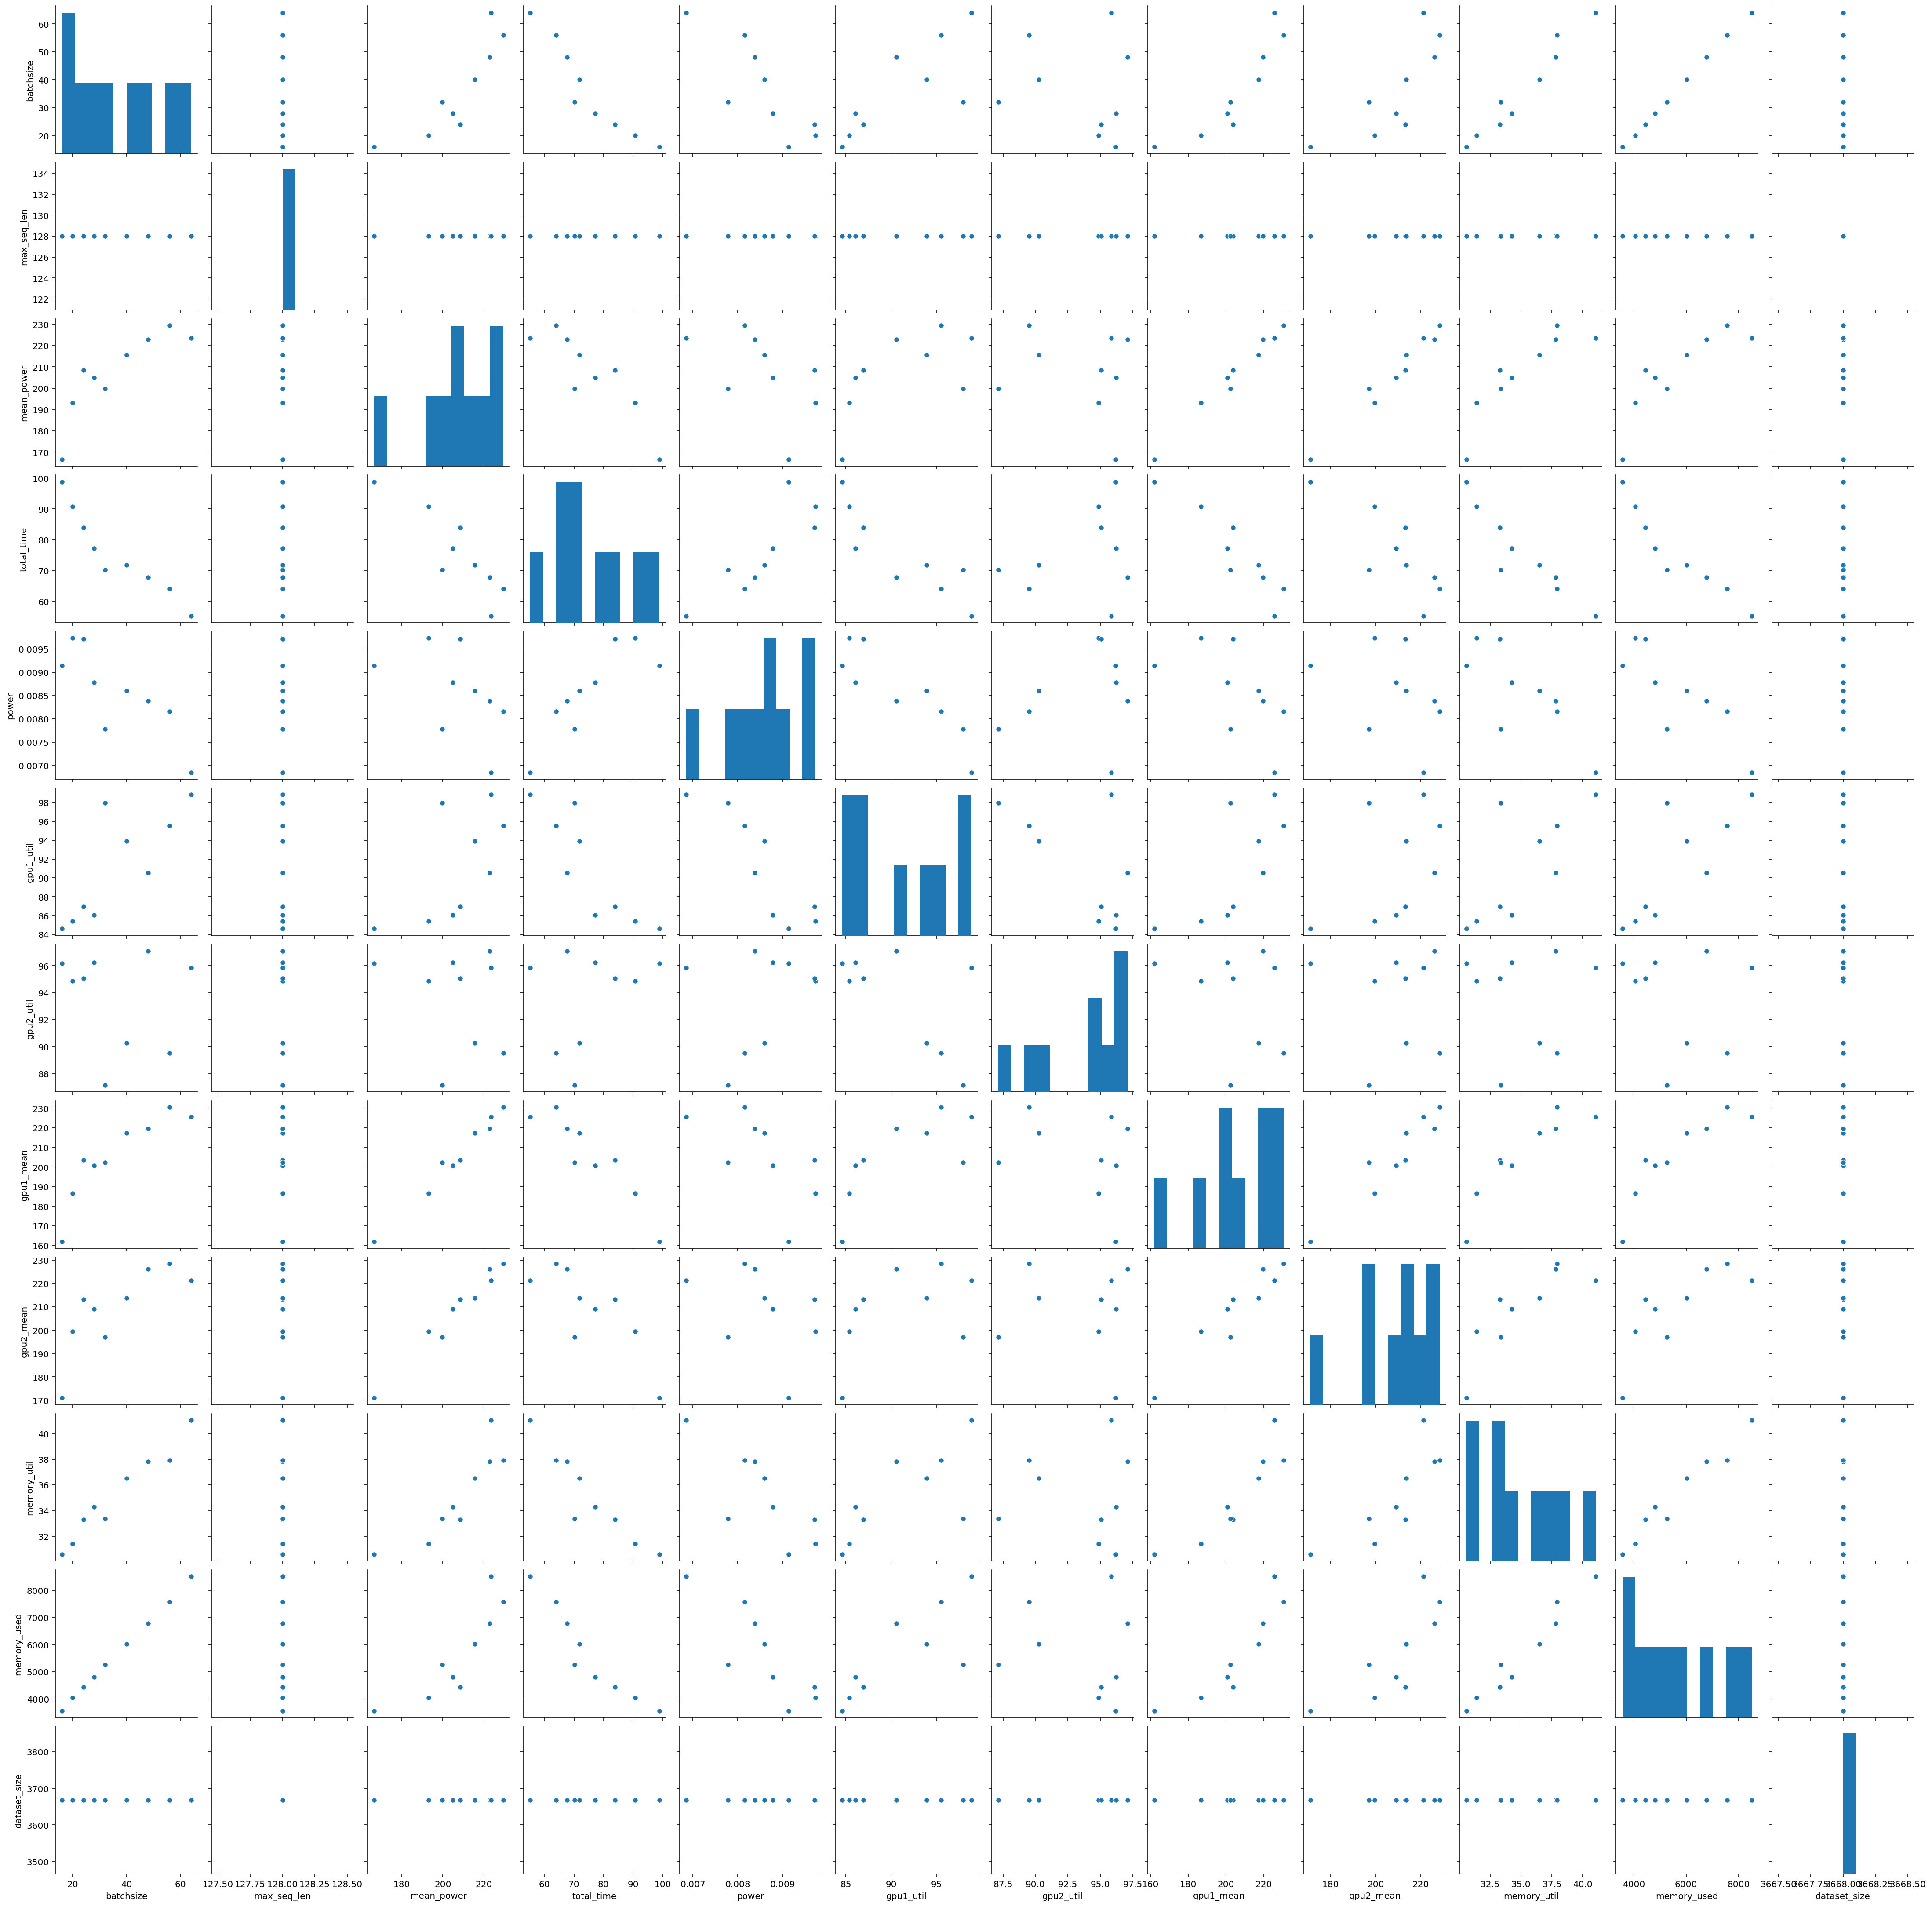

In [54]:
#sns.pairplot(df_mrpc)

## Regression models to predict time, power, gpu util, memory util

the quantity of data still bothers me

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit

In [83]:
models = dict(
    linear_reg=LinearRegression(normalize=True),
    random_forest = RandomForestRegressor(random_state=1),
    xgboost=XGBRegressor(random_state=1)
)

In [84]:
def run_models_cv(result):
    features = ['batchsize','max_seq_len','dataset_size']
    X = result[features]
    targets = ['mean_power','total_time','gpu_util','memory_util']
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    for target in targets:
        y = result[target]
        #print ("________{}_________".format(target))
        
        for name, model in models.items():
            #print(name)
            scores = cross_val_score(model, X, y, cv=cv)
            yield target, name, scores

In [85]:
# features = ['batchsize','max_seq_len','dataset_size']
# X = result[features]
# y = result['mean_power']
# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
# linear_reg=LinearRegression(normalize=True)
# scores = cross_val_score(linear_reg, X, y, cv=cv)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [86]:
df_cv = pd.DataFrame(columns=("target", "model","score","std"))
for target, name, scores in run_models_cv(result):
    score_result = dict(target=target,
                       model=name,
                       score=scores.mean(),
                       std=scores.std() * 2)
    df_cv = df_cv.append(score_result,ignore_index=True)
df_cv.to_csv('results/run_models_results.csv', index=False)
df_cv

,target,model,score,std
0,mean_power,linear_reg,0.325059,1.028516
1,mean_power,random_forest,0.405002,0.215051
2,mean_power,xgboost,0.603452,0.408237
3,total_time,linear_reg,0.908401,0.197366
4,total_time,random_forest,0.706233,0.651727
5,total_time,xgboost,0.665177,0.569400
6,gpu_util,linear_reg,-1.056218,4.592831
7,gpu_util,random_forest,0.138044,0.951211
8,gpu_util,xgboost,-0.131969,1.443928
9,memory_util,linear_reg,0.791350,0.171272


### ummm...

In [80]:
def run_models_kfold(result):
    features = ['batchsize','max_seq_len','dataset_size']
    X = result[features]
    targets = ['mean_power','total_time','gpu_util','memory_util']
    kf = KFold(n_splits=3, shuffle=True, random_state=1)
    
    for target in targets:
        y = result[target]
        #print ("________{}_________".format(target))
        fold_id = 0
        for train_index, test_index in kf.split(X):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            for name, model in models.items():
                #print(name)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                yield fold_id, target, name, r2, mae, sqrt(mse)
            fold_id += 1

In [81]:
df_models = pd.DataFrame(columns=('fold_id','target','model_name','r2','mean_abs_error','root_mean_sqr_error'))

In [82]:
for fold_id, target, name, r2, mae, rmse in run_models_kfold(result):
    model_result = dict(fold_id=fold_id,
                        target=target,
                        model_name=name,
                        r2=r2,
                        mean_abs_error=mae,
                        root_mean_sqr_error=rmse)
    #print(model_result)
    df_models = df_models.append(model_result,ignore_index=True)


In [83]:
df_models

,fold_id,target,model_name,r2,mean_abs_error,root_mean_sqr_error
0,0,mean_power,linear_reg,0.644963,7.204547,8.838259
1,0,mean_power,random_forest,0.624146,6.462525,9.093680
2,0,mean_power,xgboost,0.634857,6.261387,8.963171
3,1,mean_power,linear_reg,0.657161,8.164857,11.564782
4,1,mean_power,random_forest,0.506018,10.570125,13.881865
5,1,mean_power,xgboost,0.452974,11.799270,14.608186
6,2,mean_power,linear_reg,0.638176,6.774865,8.917388
7,2,mean_power,random_forest,0.412036,7.515732,11.367488
8,2,mean_power,xgboost,0.316577,8.370233,12.255581
9,0,total_time,linear_reg,0.341178,430.241765,641.800214


In [49]:
xgboost=XGBRegressor(random_state=1)
features = ['batchsize','max_seq_len','dataset_size']
X = result[features]
y = result['mean_power']
xgboost.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
def feature_imp(model, train_X):
    feature_importances = pd.DataFrame(model.feature_importances_,
    index = train_X.columns,
    columns=['importance']).sort_values('importance', ascending=False)
    sns.barplot(data=feature_importances.reset_index(),x='importance',y='index',orient='h')

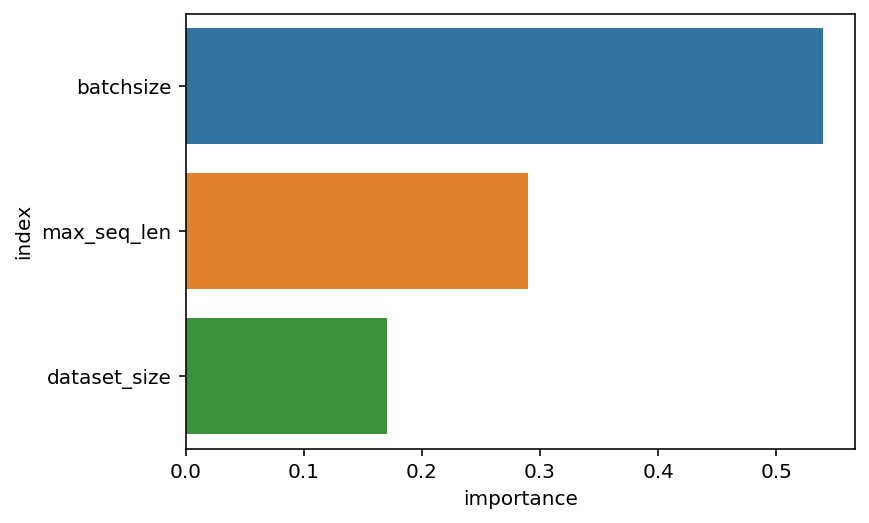

In [51]:
feature_imp(xgboost,X)

In [52]:
forest_model=RandomForestRegressor(random_state=1)
features = ['batchsize','max_seq_len','dataset_size']
X = result[features]
y = result['mean_power']
forest_model.fit(X,y)

RandomForestRegressor(random_state=1)

In [53]:
forest_model.predict([[30,128,3668]])

array([204.19958745])

In [54]:
forest_model.predict([[50,128,3668]])

array([224.22829697])

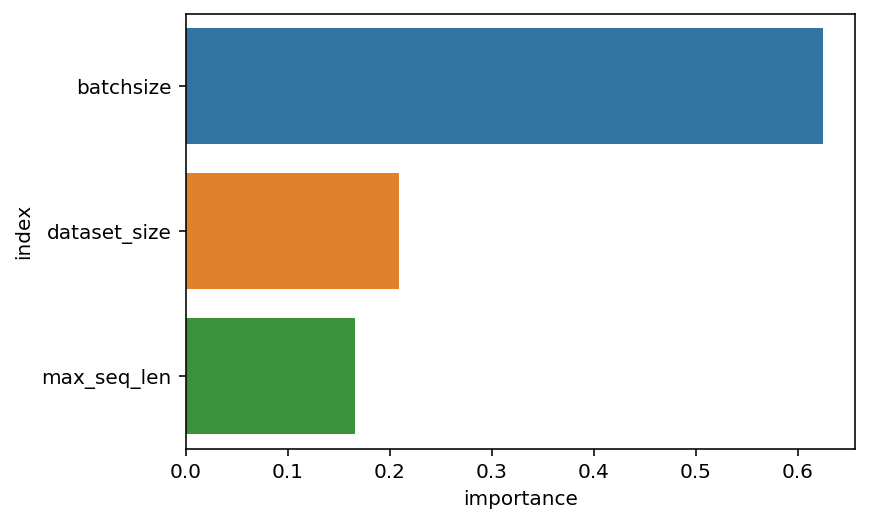

In [55]:
feature_imp(forest_model,X)

In [122]:
url = 'nvidia/nvidia_power_CoLA_32_128.csv'
df, x= power_reading(url)

In [123]:
df.columns

Index(['timestamp', ' utilization.gpu [%]', ' utilization.memory [%]',
       ' memory.total [MiB]', ' memory.used [MiB]', ' memory.free [MiB]',
       ' temperature.gpu', ' power.draw [W]', ' pstate'],
      dtype='object')

In [119]:
#sns.pairplot(df)